# Datensatz herunterladen
Link: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import keras
import tensorflow as tf
import os
import random
warnings.filterwarnings('ignore')


# Korrumpierte Bilder herausfiltern
Bei der Arbeit mit vielen realen Bilddaten sind beschädigte Bilder ein häufiges Phänomen -> Schlecht kodierte Bilder herausfiltern, die nicht die Zeichenfolge "JFIF" in ihrem Header enthalten.

In [38]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# Dataframe erstellen

In [8]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Cat/504.jpg 0


In [9]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0   PetImages/Cat/2539.jpg      0
1   PetImages/Dog/1039.jpg      1
2   PetImages/Dog/3063.jpg      1
3  PetImages/Cat/11688.jpg      0
4   PetImages/Cat/8149.jpg      0

In [10]:
for i in df['images']:
  if '.jpg' not in i:
    print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [11]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
len(df)

23410

# Datenanalyse

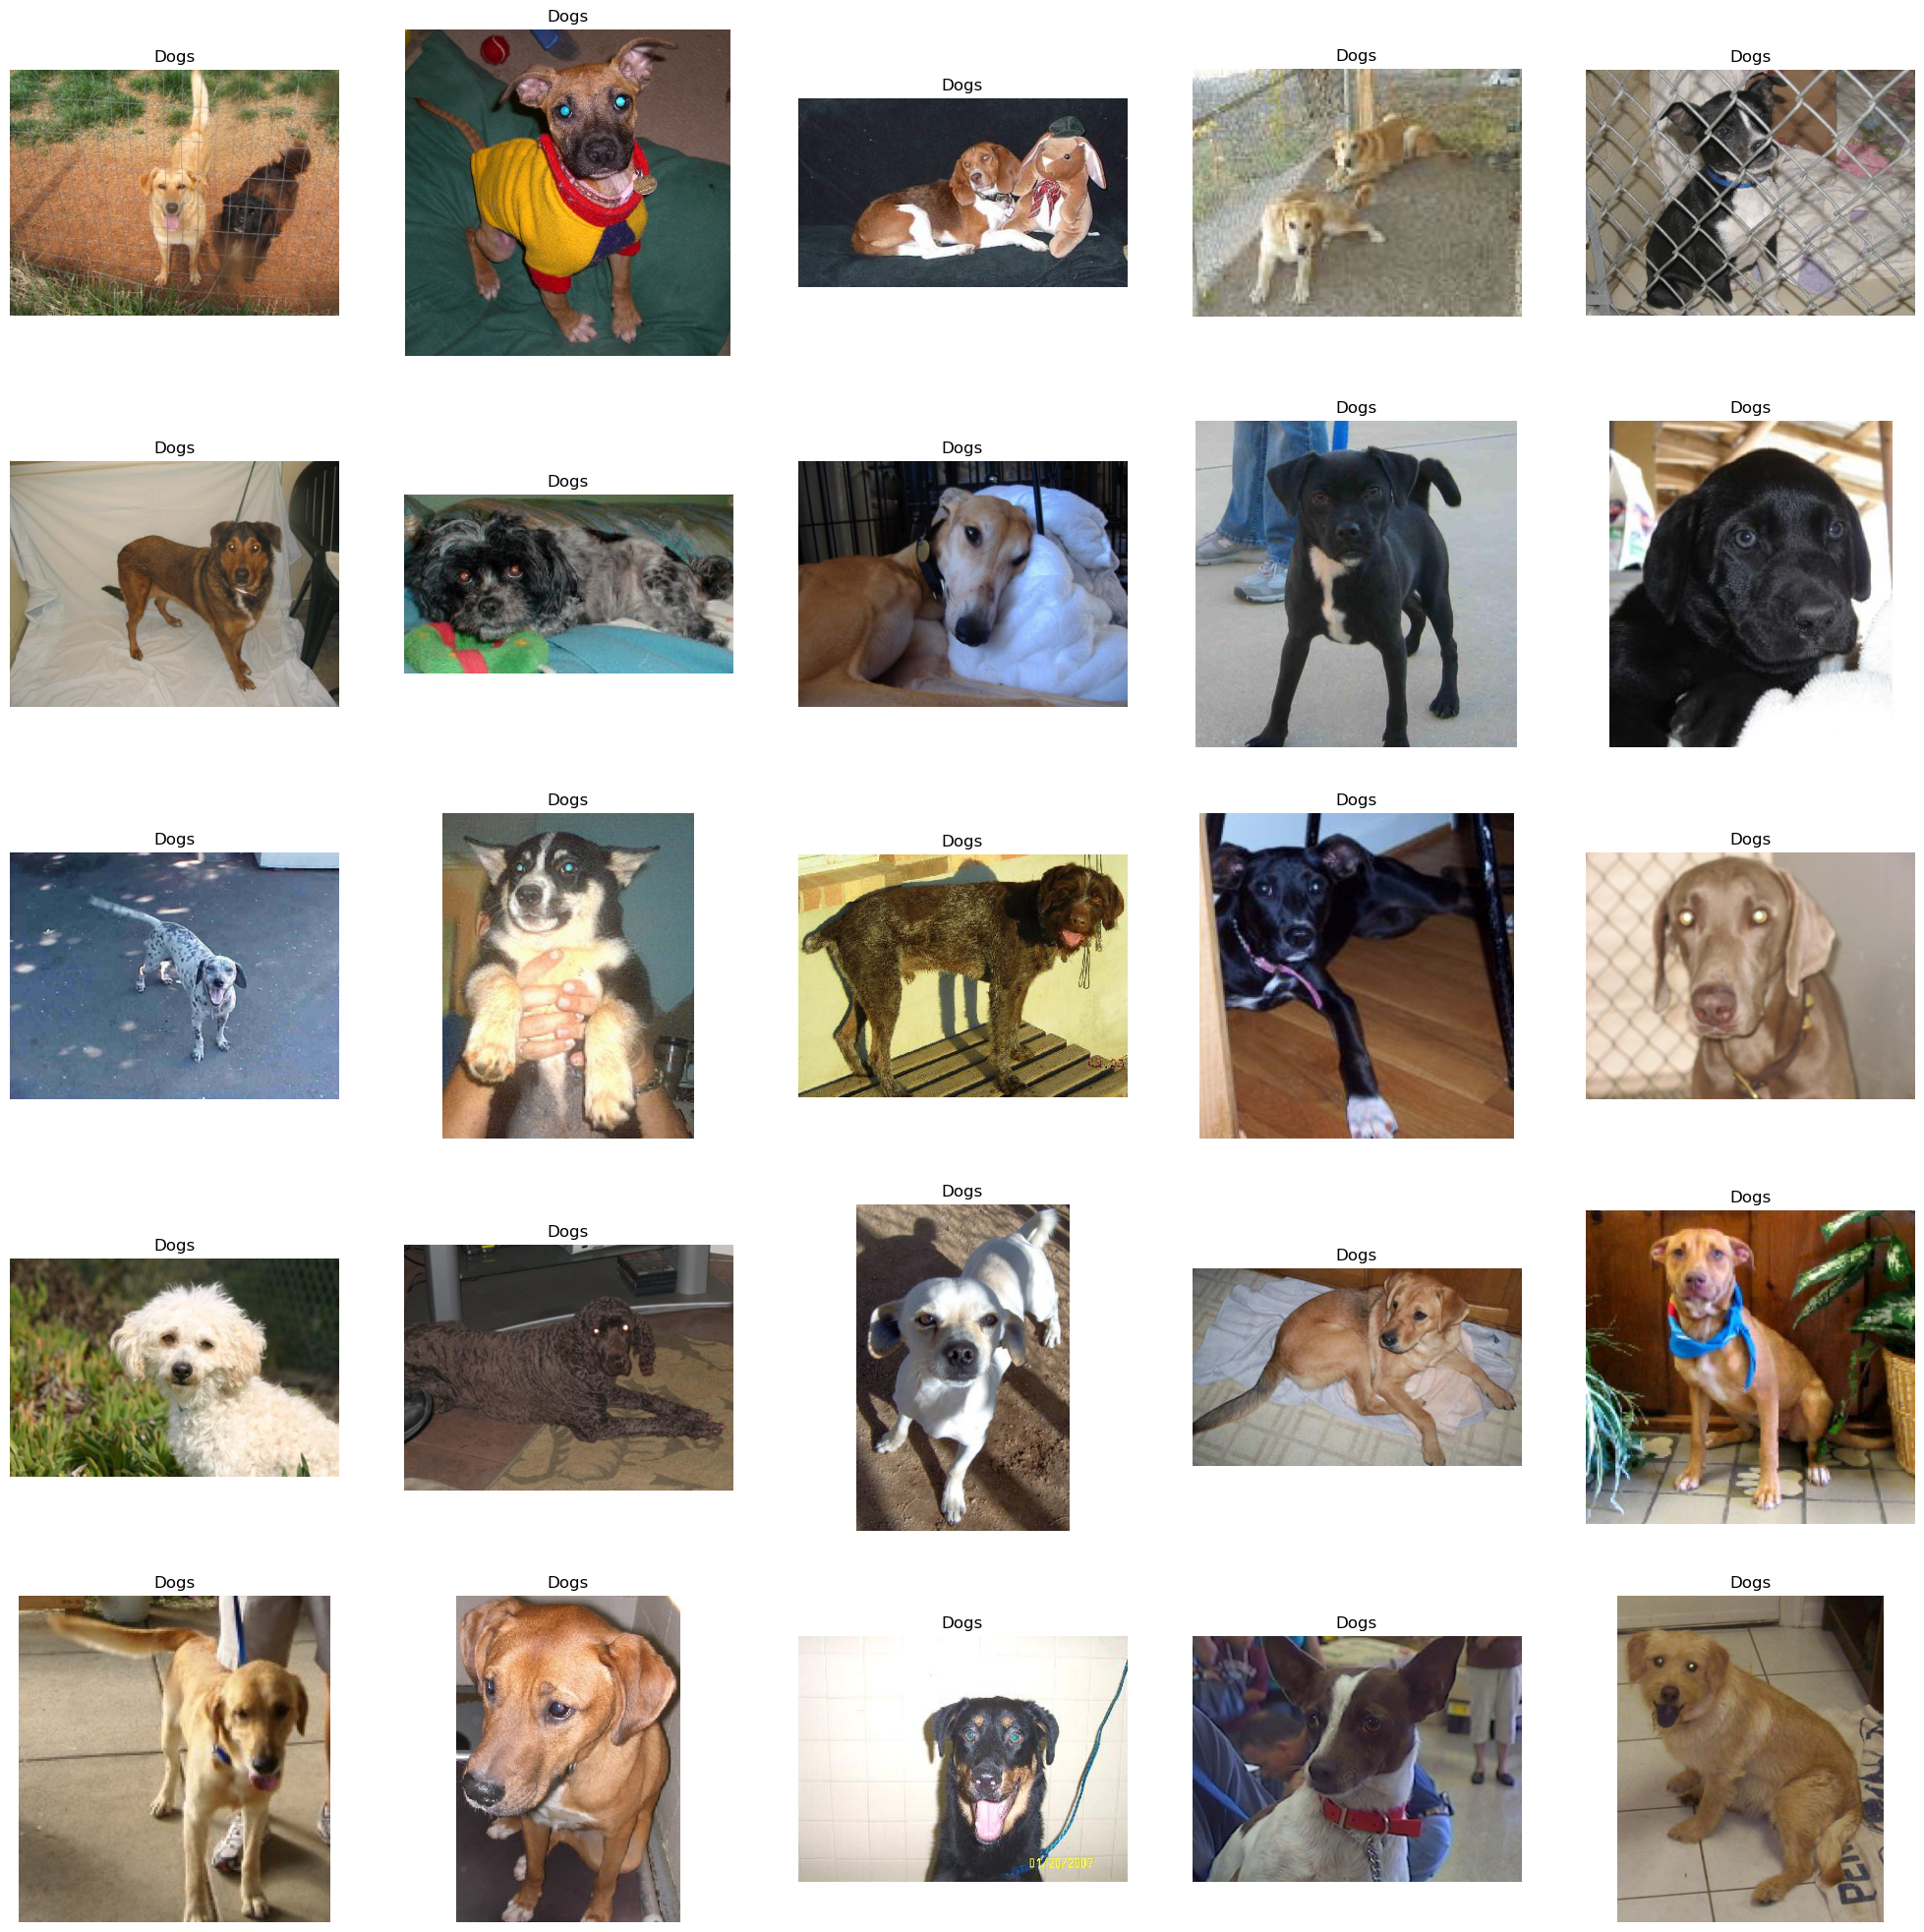

In [12]:
# display grid of images
plt.figure(figsize=(25, 25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for i, file in enumerate(files):
  plt.subplot(5, 5, i+1)
  img = plt.imread(file)
  plt.imshow(img)
  plt.title("Dogs")
  plt.axis('off')

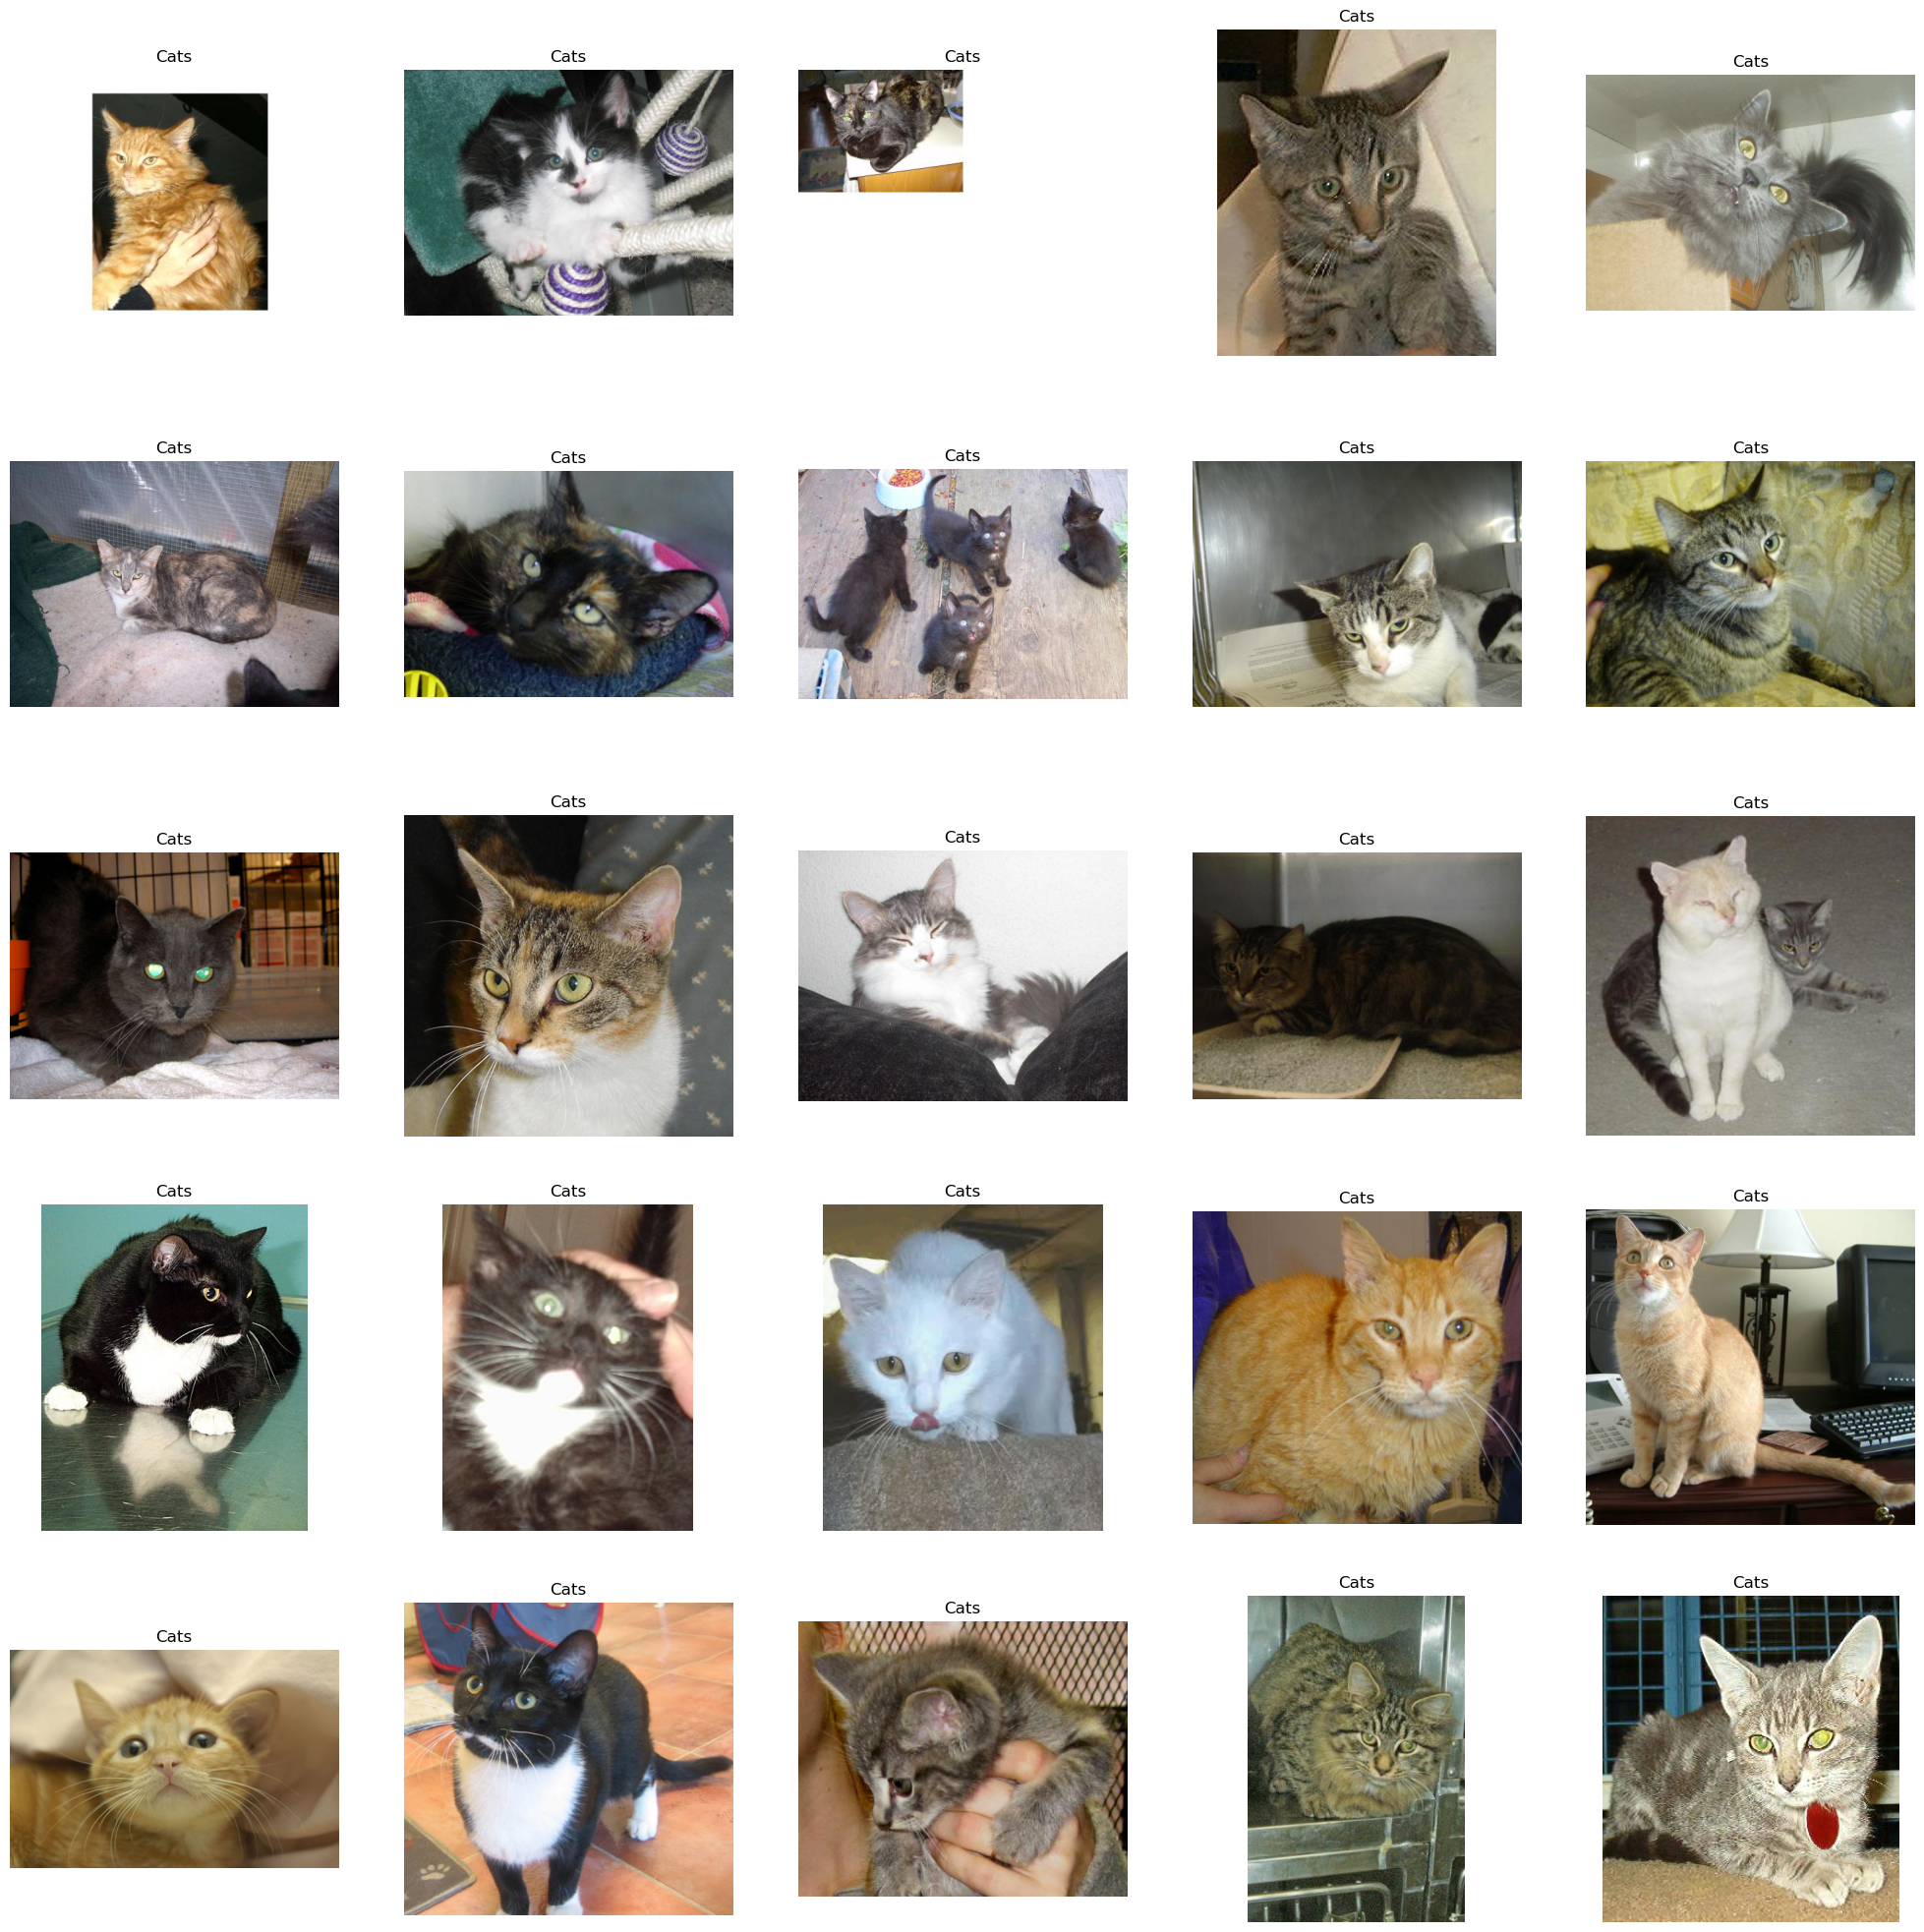

In [13]:
# display grid of images
plt.figure(figsize=(25, 25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for i, file in enumerate(files):
  plt.subplot(5, 5, i+1)
  img = plt.imread(file)
  plt.imshow(img)
  plt.title("Cats")
  plt.axis('off')

In [39]:
df['label'].value_counts()

label
0    11741
1    11669
Name: count, dtype: int64

# Create DataGenerator for the Images

In [16]:
df['label'] = df['label'].astype('str')

In [17]:
df.head()

images label
0   PetImages/Cat/2539.jpg     0
1   PetImages/Dog/1039.jpg     1
2   PetImages/Dog/3063.jpg     1
3  PetImages/Cat/11688.jpg     0
4   PetImages/Cat/8149.jpg     0

In [18]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.


# Model Creation

In [20]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [22]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10


2024-01-08 12:48:25.733496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.5318

2024-01-08 12:50:14.125000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - 119s 3s/step - loss: 0.7183 - accuracy: 0.5318 - val_loss: 0.6523 - val_accuracy: 0.6074
Epoch 2/10
37/37 [==============================] - 108s 3s/step - loss: 0.6355 - accuracy: 0.6359 - val_loss: 0.6018 - val_accuracy: 0.6704
Epoch 3/10
37/37 [==============================] - 106s 3s/step - loss: 0.5862 - accuracy: 0.6881 - val_loss: 0.5453 - val_accuracy: 0.7221
Epoch 4/10
37/37 [==============================] - 106s 3s/step - loss: 0.5591 - accuracy: 0.7150 - val_loss: 0.5688 - val_accuracy: 0.6993
Epoch 5/10
37/37 [==============================] - 106s 3s/step - loss: 0.5414 - accuracy: 0.7251 - val_loss: 0.5065 - val_accuracy: 0.7548
Epoch 6/10
37/37 [==============================] - 107s 3s/step - loss: 0.5177 - accuracy: 0.7436 - val_loss: 0.4934 - val_accuracy: 0.7678
Epoch 7/10
37/37 [==============================] - 106s 3s/step - loss: 0.4979 - accuracy: 0.7582 - val_loss: 0.4944 - val_accuracy: 0.7614
Epoch 8/10
37/37 [======

# Visualisierung der Ergebnisse

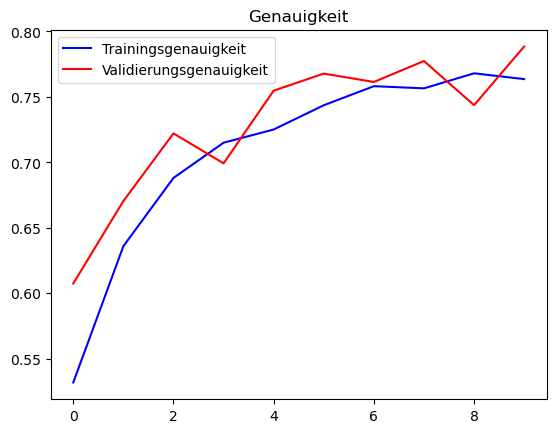

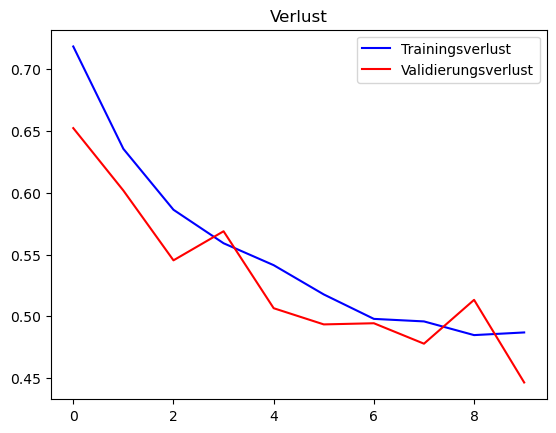

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'r', label='Validierungsgenauigkeit')
plt.title('Genauigkeit')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'r', label='Validierungsverlust')
plt.title('Verlust')
plt.legend()
plt.show()

# Echtes Bild testen

1/1 [==============================] - 0s 20ms/step
Cat


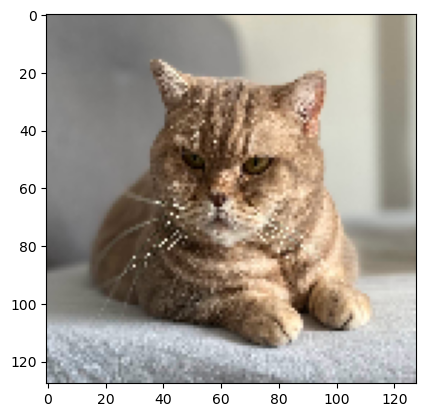

In [41]:

image_path = "katze.jpg" # path of the image
img = keras.utils.load_img(image_path, target_size=(128, 128))
plt.imshow(img)

img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)